### Import Libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plot
import numpy as np
import os

### Initialization with 20 Epochs and 32 Batches and set images' path

In [34]:
initLayer = 1e-4
epochs = 5
batch = 32

### Setting Up Image Data

In [35]:
current_dir = os.getcwd()
relative_dataset_dir = "../dataset"
dataset_dir = os.path.join(current_dir, relative_dataset_dir)

categories = ["with_mask", "without_mask"]

data = []
labels = []
for category in categories:
	path = os.path.join(dataset_dir, category)
	for img in os.listdir(path):
		img_path = os.path.join(path, img)
		image = load_img(img_path, target_size=(224, 224))
		image = img_to_array(image)
		image = preprocess_input(image)
		data.append(image)
		labels.append(category)

### Encode Data and Labels

In [36]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data,dtype="float32")
labels = np.array(labels)

### Set 80% of Images for training and 20% for testing

In [37]:
(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=20)

In [38]:
# Use ImageDataGenerator for both training and validation data
trainAug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()

### Load MibileNetV2 network

In [39]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\91982\AppData\Local\Temp\ipykernel_30260\2912745669.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


### Construct the head module

In [40]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

### Pace the head FC model on top of the base model (this will become the actual model we will train)

In [41]:
model = Model(inputs=baseModel.input, outputs=headModel)

### Loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [42]:
for layer in baseModel.layers:
	layer.trainable = False

### Compile the neural network Module

In [43]:
opt = Adam(learning_rate=initLayer, decay=initLayer / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

c:\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Train the head of the module

In [44]:
# Fit the model
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=batch),
    validation_data=valAug.flow(testX, testY),
    epochs=epochs)

c:\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


c:\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_477']. Received: the structure of inputs=*
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.6449 - loss: 0.7099 - val_accuracy: 0.9883 - val_loss: 0.2430
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9469 - loss: 0.2626 - val_accuracy: 0.9961 - val_loss: 0.0968
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9830 - loss: 0.1400 - val_accuracy: 0.9961 - val_loss: 0.0554
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9815 - loss: 0.1048 - val_accuracy: 0.9961 - val_loss: 0.0390
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9824 - loss: 0.0709 - val_accuracy: 0.9961 - val_loss: 0.0282


### Serialize the model to disk

In [45]:
model.save("mask_detector.h5")

In [46]:
print("Length of loss array: ", len(H.history["loss"]))
print("Length of val_loss array: ", len(H.history["val_loss"]))
print("Length of accuracy array: ", len(H.history["accuracy"]))
print("Length of val_accuracy array: ", len(H.history["val_accuracy"]))

Length of loss array:  5
Length of val_loss array:  5
Length of accuracy array:  5
Length of val_accuracy array:  5


### Plot the training loss and accuracy

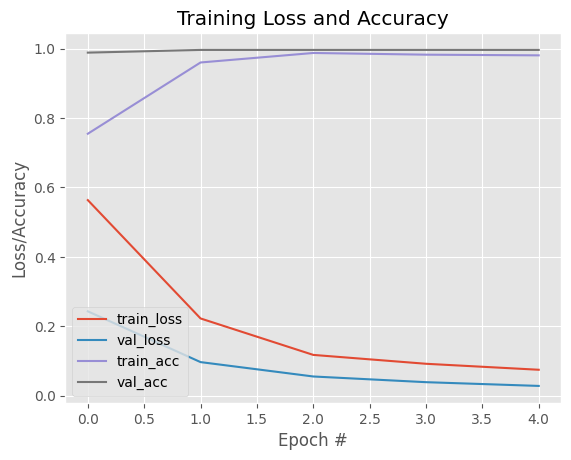

In [49]:
N = len(H.history["loss"])
plot.style.use("ggplot")
plot.figure()
plot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plot.title("Training Loss and Accuracy")
plot.xlabel("Epoch #")
plot.ylabel("Loss/Accuracy")
plot.legend(loc="lower left")
plot.savefig("plot.png")